## Advanced Modeling of VSTOXX Index

* Square root jump diffusion: Extend the square root diffusion based model to include jumps
* This model adds term structure components and jump component
* With the ability to model jump component we can better model short-term maturity options
* With the term-structure component we can better model pricing of longer dated maturities

In [25]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
%matplotlib inline
path = 'data/'
h5 = pd.HDFStore(path + 'vstoxx_data_31032014.h5', 'r')

In [26]:
option_quotes = h5['options_data']
option_quotes.info()
option_quotes.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
DATE         395 non-null int64
EXP_YEAR     395 non-null int64
EXP_MONTH    395 non-null int64
TYPE         395 non-null object
STRIKE       395 non-null float64
PRICE        395 non-null float64
MATURITY     395 non-null int64
TTM          395 non-null float64
dtypes: float64(3), int64(4), object(1)
memory usage: 27.8+ KB


,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM
46170,1396224000000000000,2014,4,C,1.0,16.85,1397779200000000000,0.049
46171,1396224000000000000,2014,4,C,2.0,15.85,1397779200000000000,0.049
46172,1396224000000000000,2014,4,C,3.0,14.85,1397779200000000000,0.049
46173,1396224000000000000,2014,4,C,4.0,13.85,1397779200000000000,0.049
46174,1396224000000000000,2014,4,C,5.0,12.85,1397779200000000000,0.049


In [27]:
option_quotes['MATURITY'] = pd.to_datetime(option_quotes['MATURITY'])
option_quotes['DATE'] = pd.to_datetime(option_quotes['DATE'])

In [28]:
mats = sorted(set(option_quotes['MATURITY']))
mats

[Timestamp('2014-04-18 00:00:00'),
 Timestamp('2014-05-16 00:00:00'),
 Timestamp('2014-06-20 00:00:00'),
 Timestamp('2014-07-18 00:00:00'),
 Timestamp('2014-08-15 00:00:00'),
 Timestamp('2014-09-19 00:00:00'),
 Timestamp('2014-10-17 00:00:00'),
 Timestamp('2014-11-21 00:00:00')]

In [29]:
v0 = 17.6639
tol = 0.4
to_plot = option_quotes[(option_quotes['STRIKE'] > (1 - tol) * v0)
                      & (option_quotes['STRIKE'] < (1 + tol) * v0)]

#### Term structure for different maturities and strikes

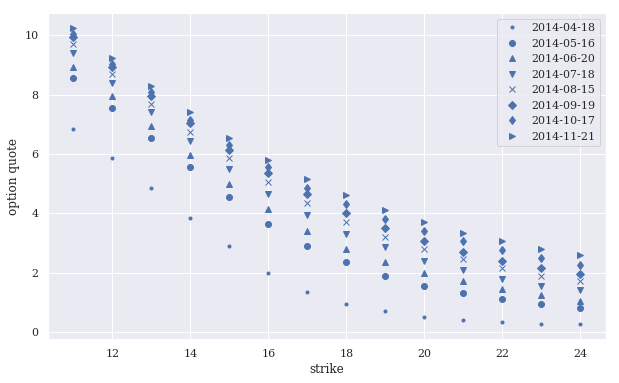

In [30]:
markers = ['.', 'o', '^', 'v', 'x', 'D', 'd', '>', '<']
plt.figure(figsize=(10, 6));
for i, mat in enumerate(mats):
    strikes = to_plot[(to_plot['MATURITY'] == mat)]['STRIKE']
    prices = to_plot[(to_plot['MATURITY'] == mat)]['PRICE']
    plt.plot(strikes, prices, 'b%s' % markers[i], label=str(mat)[:10])
plt.legend();
plt.xlabel('strike');
plt.ylabel('option quote');

In [31]:
futures_quotes = h5['futures_data']
futures_quotes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 496 to 503
Data columns (total 6 columns):
DATE         8 non-null int64
EXP_YEAR     8 non-null int64
EXP_MONTH    8 non-null int64
PRICE        8 non-null float64
MATURITY     8 non-null int64
TTM          8 non-null float64
dtypes: float64(2), int64(4)
memory usage: 448.0 bytes


In [32]:
futures_quotes['MATURITY'] = pd.to_datetime(futures_quotes['MATURITY'])

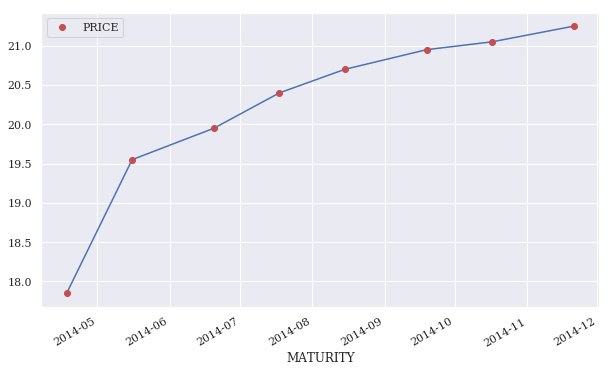

In [33]:
ax = futures_quotes.plot(x='MATURITY', y='PRICE',
                         figsize=(10, 6), legend=False)
futures_quotes.plot(x='MATURITY', y='PRICE', style='ro', ax=ax);

#### Term structure calibration

* Account for different term structures of the short rate
* Deterministic shift approach allows us to handle this 
* We will use the deterministic shift approach to value the square root diffusion process
* We will then combine this with the jump component to better value our options
* Calibrate $dv_t = \kappa (\theta - v_t)dt + \sigma\sqrt{v_t} dZ_t$ to observed volatility term structure for futures on VSTOXX index for different maturities and strikes
* Need to minimize at every time step $t$ and parameter set $\alpha = (\kappa, \theta, \sigma, v_0)$ simultaneously the single difference
    * $\Delta f(0, t)  = f(0, t)  - f^{GL96}(0,t; \alpha)$
    * $f(0,t)$ is the market vol
    * $f^{GL96}(0,t; \alpha)$ is the modeled vol

* To use the deterministic shift approach we do some mathmagic

* First compute modeled forward rates
* Next compute error between forward rate and market quote
* 

In [34]:
import sys
sys.path.append('scripts/')

In [35]:
%run scripts/srjd_fwd_calibration.py

 1.000 17.500  1.000    35.99817
 0.258 40.585  0.057     5.61895
 1.575 46.996  0.392     0.22958
 2.525 46.207  0.710     0.06348
 3.447 44.752  0.972     0.04264
 3.538 44.458  0.903     0.04261
 3.947 43.495  0.610     0.04243
 4.113 43.102  0.275     0.04219
 4.187 42.969  0.019     0.04213
 4.169 42.984  0.002     0.04213
 4.170 42.984  0.000     0.04213
Optimization terminated successfully.
         Current function value: 0.042129
         Iterations: 292
         Function evaluations: 526


* Alpha Parameters than minimize the error

In [36]:
opt.round(3)

array([  4.17 ,  42.984,   0.   ])

* Plug in the alpha parameters to get repriced forwards for our term structure

In [37]:
from srjd_fwd_calibration import *
srd_fwds = srd_forwards(opt)
srd_fwds

array([ 17.6639    ,  18.37130183,  19.22831373,  19.97504105,
        20.3916346 ,  20.69048824,  20.95488999,  21.10239774,  21.23092346])

In [38]:
srd_fwds - forwards

array([ 0.        ,  0.52130183, -0.32168627,  0.02504105, -0.0083654 ,
       -0.00951176,  0.00488999,  0.05239774, -0.01907654])

* For forwards longer out in the term structure the estimate is pretty accurate

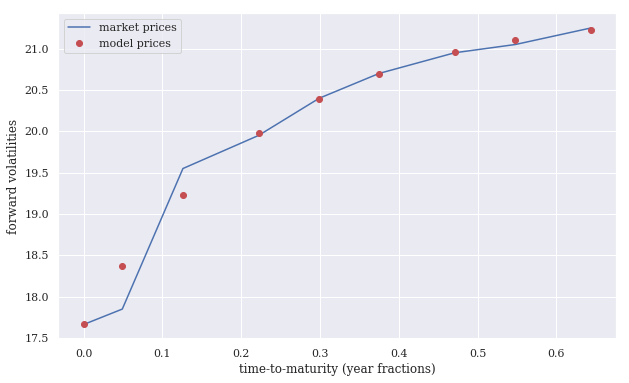

In [39]:
plt.figure(figsize=(10, 6));
plt.plot(ttms, forwards, 'b', label='market prices');
plt.plot(ttms, srd_fwds, 'ro', label='model prices');
plt.legend(loc=0);
plt.xlabel('time-to-maturity (year fractions)');
plt.ylabel('forward volatilities');

### Shifted Volatility Process

* The difference between the modeled and the market price is the value in the bars

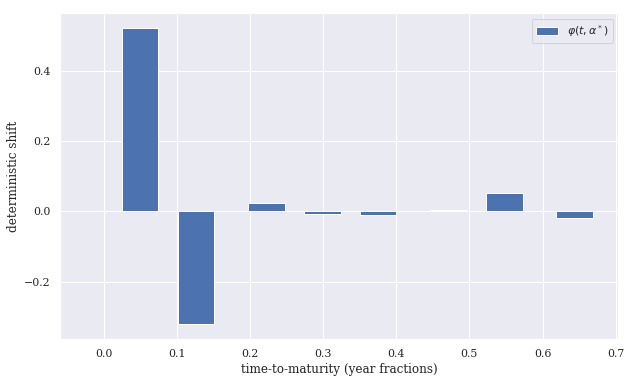

In [40]:
plt.figure(figsize=(10, 6));
plt.bar(ttms, srd_fwds - forwards,
            width=0.05, label='$\\varphi(t,\\alpha^*)$');
plt.legend(loc=0);
plt.xlabel('time-to-maturity (year fractions)');
plt.ylabel('deterministic shift');

#### MCS with deterministic shift

* Euler Discretization 
* Each option is valued with the same set of pseudo-random numbers
* Variance reduction with moment matching and antithetic paths
* Deterministic shift, computed once and held constant even if model params change 
* Cubic spline interpolation is used to fill in the gaps within the term structure 
* Using numpy we can fully vectorize the Monte Carlo with the random number generation and the use of matrices
* Run the simulation then the valuation
* This is done for a single strike price, and single time horizon
* Cool!


In [41]:
%run scripts/srjd_simulation.py

Value of European call by MCS:     0.9805


In [42]:
h5 = pd.HDFStore(path + 'vstoxx_march_2014.h5', 'r')

# read option data from file and close it
option_data = h5['vstoxx_options']
h5.close()
# select relevant date for call option quotes
option_data['MATURITY'] = pd.to_datetime(option_data['MATURITY'])
option_data['DATE'] = pd.to_datetime(option_data['DATE'])
option_data = option_data[(option_data.DATE == '2014-3-31')
                        & (option_data.TYPE == 'C')]
# calculate time-to-maturity in year fractions
option_data['TTM'] = (option_data.MATURITY - option_data.DATE).apply(
                    lambda x: x / np.timedelta64(1, 'D') / 365.)

# only those options close enough to the ATM level
option_data = option_data[(option_data.STRIKE > (1 - tol) * v0)
                        & (option_data.STRIKE < (1 + tol) * v0)]

In [43]:
#option_data

In [44]:
from srjd_model_calibration import *
## read option data, allow for 30% moneyness tolerance
option_data = read_select_quotes(tol=0.3)

In [45]:
option_data.head()

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM
46182,2014-03-31,2014,4,C,13.0,4.85,2014-04-18,0.049315
46183,2014-03-31,2014,4,C,14.0,3.85,2014-04-18,0.049315
46184,2014-03-31,2014,4,C,15.0,2.90,2014-04-18,0.049315
46185,2014-03-31,2014,4,C,16.0,2.00,2014-04-18,0.049315
46186,2014-03-31,2014,4,C,17.0,1.35,2014-04-18,0.049315


* Calibration now requires more inputs and a specific maturity date

In [50]:
%%time
opt_1 = srjd_model_calibration(option_data, p0=None,
                               rel=False, mats=['2014-4-18'])


  its  kappa  theta  sigma   lamb     mu  delta         MSE     min_MSE
    0  1.000 10.000  1.000  0.000 -0.200  0.000     0.15785     0.15785
  100  1.000 20.000  3.000  0.800 -0.200  0.000     0.10867     0.01976
  200  5.000 20.000  3.000  0.400 -0.200  0.150     0.27793     0.01976
  300  9.000 20.000  3.000  0.000 -0.200  0.300     0.70669     0.01976

  its  kappa  theta  sigma   lamb     mu  delta         MSE     min_MSE
    0  1.000 10.000  3.000  0.400 -0.200  0.000     0.01976     0.01976
  100  1.016  9.216  2.996  0.476 -0.124  0.001     0.01956     0.01955
  200  1.020  9.213  3.006  0.494 -0.128  0.001     0.01955     0.01955
  300  0.976  8.895  3.000  0.392 -0.128  0.001     0.02214     0.01955
  400  0.977  8.869  3.002  0.394 -0.128  0.001     0.01955     0.01955
  500  0.976  8.866  3.002  0.394 -0.128  0.001     0.01955     0.01955
  600  0.976  8.867  3.002  0.394 -0.128  0.001     0.01955     0.01955
CPU times: user 8.33 s, sys: 91 ms, total: 8.43 s
Wall time: 8

In [47]:
opt_1

array([  9.75770825e-01,   8.86539094e+00,   3.00188833e+00,
         3.93539089e-01,  -1.28094441e-01,   1.26180667e-03])

In [51]:
values = []
kappa, theta, sigma, lamb, mu, delta = opt_1
for i, option in option_data.iterrows():
    value = srjd_call_valuation(v0, kappa, theta, sigma,
                                lamb, mu, delta,
                                option['TTM'], r, option['STRIKE'],
                                M=M, I=I, fixed_seed=True)
    values.append(value)
option_data['MODEL'] = values

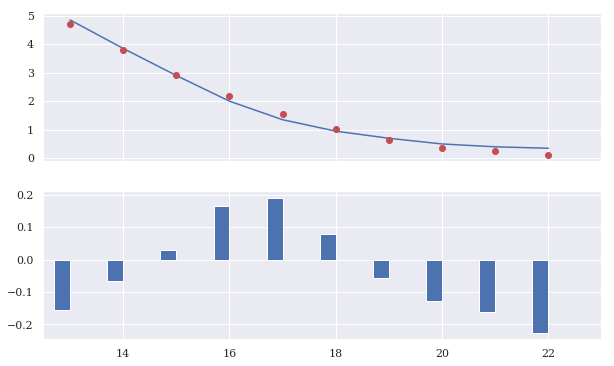

In [52]:
## selecting the data for the shortest maturity
os = option_data[option_data.MATURITY == '2014-4-18']
## selecting corresponding strike prices
strikes = os.STRIKE.values
## comparing the model prices with the market quotes
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 6));
ax[0].plot(strikes, os.PRICE.values, label='market quotes');
ax[0].plot(strikes, os.MODEL.values, 'ro', label='model prices');
ax[1].bar(strikes - 0.15, os.MODEL.values - os.PRICE.values,
                        width=0.3);
ax[1].set_xlim(12.5, 23);

In [53]:
option_data = read_select_quotes(tol=0.175)

#### Calibration with two maturities

In [54]:
%%time
opt_2 = srjd_model_calibration(option_data, rel=False,
                            mats=['2014-5-16', '2014-7-18'])


  its  kappa  theta  sigma   lamb     mu  delta         MSE     min_MSE
    0  1.000 10.000  1.000  0.000 -0.200  0.000     8.71137     8.71137
  100  1.000 20.000  3.000  0.800 -0.200  0.000     0.85126     0.10351
  200  5.000 20.000  3.000  0.400 -0.200  0.150     0.59218     0.09015
  300  9.000 20.000  3.000  0.000 -0.200  0.300     0.45081     0.01539

  its  kappa  theta  sigma   lamb     mu  delta         MSE     min_MSE
    0  5.000 20.000  3.000  0.800  0.400  0.000     0.01539     0.01539
  100  4.471 19.655  3.256  0.762  0.424  0.000     0.00892     0.00892
  200  4.010 19.231  2.730  0.761  0.575  0.002     0.00792     0.00792
  300  4.023 18.987  2.321  0.721  0.668  0.003     0.01182     0.00688
  400  3.803 18.830  2.115  0.722  0.701  0.003     0.00660     0.00660
  500  3.823 18.799  2.106  0.723  0.706  0.003     0.00644     0.00644
  600  3.998 18.681  1.916  0.728  0.749  0.003     0.00598     0.00598
CPU times: user 9.71 s, sys: 96.5 ms, total: 9.81 s
Wall time:

In [55]:
opt_2

array([  3.99997568e+00,   1.86836808e+01,   1.91679210e+00,
         7.28298815e-01,   7.48260996e-01,   3.26197421e-03])

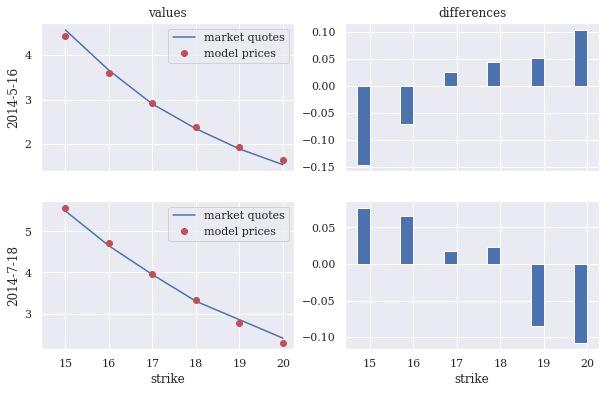

In [56]:
plot_calibration_results(option_data, opt_2, ['2014-5-16', '2014-7-18'])

#### Calibration with 4 maturities

In [57]:
mats = sorted(set(option_data['MATURITY']))
mats

[Timestamp('2014-04-18 00:00:00'),
 Timestamp('2014-05-16 00:00:00'),
 Timestamp('2014-06-20 00:00:00'),
 Timestamp('2014-07-18 00:00:00'),
 Timestamp('2014-08-15 00:00:00'),
 Timestamp('2014-09-19 00:00:00'),
 Timestamp('2014-10-17 00:00:00'),
 Timestamp('2014-11-21 00:00:00')]

In [58]:
%%time
opt_4 = srjd_model_calibration(option_data, p0=opt_2,
                               rel=False, mats=mats[::2])


  its  kappa  theta  sigma   lamb     mu  delta         MSE     min_MSE
    0  4.000 18.684  1.917  0.728  0.748  0.003     0.52345     0.52345
  100  4.202 18.938  1.980  0.727  0.623  0.003     0.27887     0.27681
  200  3.650 21.465  3.293  0.744 -0.075  0.002     0.18617     0.18617
  300  3.195 22.481  2.867  0.743 -0.223  0.000     0.14915     0.14915
  400  3.107 22.191  2.990  0.745 -0.141  0.000     0.14609     0.14608
  500  3.081 22.162  3.028  0.743 -0.138  0.000     0.14572     0.14570
  600  3.057 22.100  3.041  0.738 -0.124  0.000     0.14521     0.14521
  700  3.061 22.110  3.034  0.738 -0.126  0.000     0.14517     0.14517
CPU times: user 12.7 s, sys: 56.3 ms, total: 12.7 s
Wall time: 12.8 s


In [59]:
opt_4

array([  3.06082557e+00,   2.21100415e+01,   3.03422643e+00,
         7.38054016e-01,  -1.25823900e-01,   1.19890649e-06])

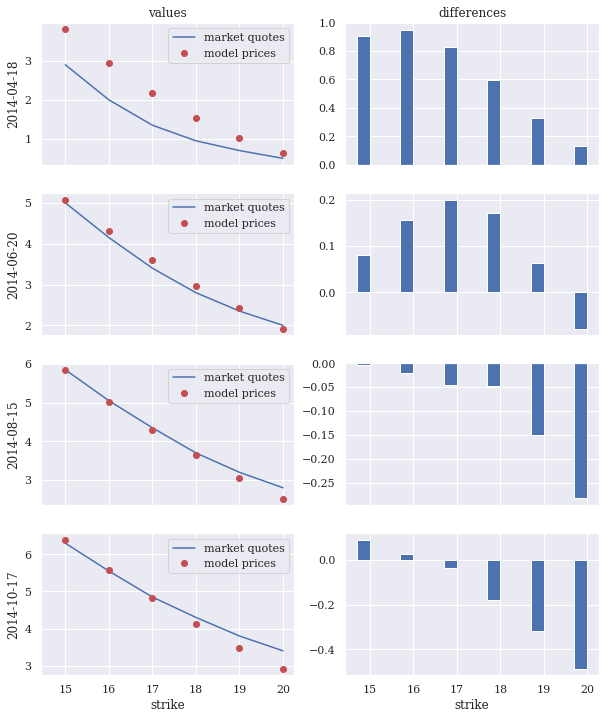

In [60]:
plot_calibration_results(option_data, opt_4, mats[::2])

#### All maturities

In [61]:
%%time
opt_8_MSAE = srjd_model_calibration(option_data,
                                rel=False, mats=mats)


  its  kappa  theta  sigma   lamb     mu  delta         MSE     min_MSE
    0  1.000 10.000  1.000  0.000 -0.200  0.000    12.79035    12.79035
  100  1.000 20.000  3.000  0.800 -0.200  0.000     1.13623     0.13849
  200  5.000 20.000  3.000  0.400 -0.200  0.150     1.08765     0.13849
  300  9.000 20.000  3.000  0.000 -0.200  0.300     1.27175     0.13849

  its  kappa  theta  sigma   lamb     mu  delta         MSE     min_MSE
    0  1.000 20.000  3.000  0.400  0.400  0.150     0.13849     0.13849
  100  1.007 20.567  2.921  0.396  0.326  0.155     0.12039     0.11935
  200  1.018 21.609  3.266  0.404  0.032  0.163     0.10182     0.10096
  300  1.033 22.713  3.222  0.407 -0.123  0.155     0.09869     0.09863
  400  1.542 23.755  3.235  0.409 -0.985  0.067     0.08329     0.08120
  500  1.860 23.848  2.967  0.410 -1.297  0.002     0.07686     0.07686
  600  1.868 23.863  2.956  0.410 -1.303 -0.000  1000.07683     0.07683
CPU times: user 38.5 s, sys: 265 ms, total: 38.8 s
Wall time: 

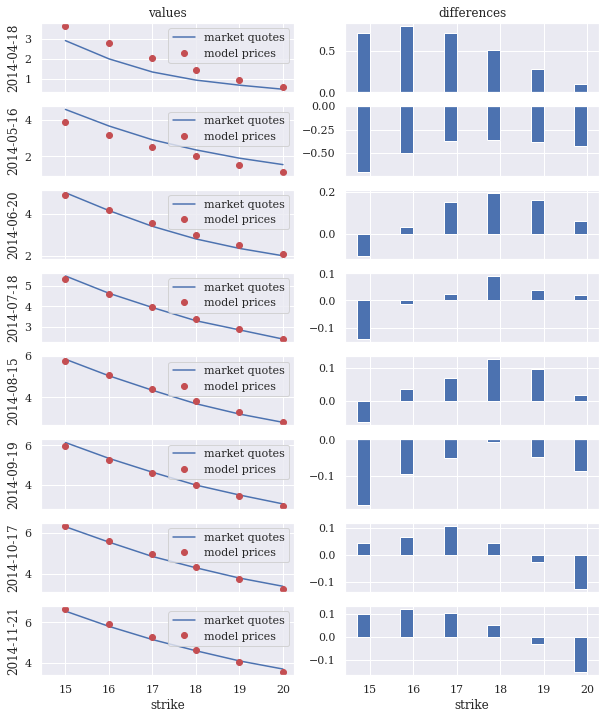

In [62]:
plot_calibration_results(option_data, opt_8_MSAE, mats)

* Using MSRE instead of MSAE results in a different weighting of options
* Options with higher strikes (lower market prices) now get a higher weight

In [64]:
%%time
opt_8_MSRE = srjd_model_calibration(option_data,
                                rel=True, mats=mats)


  its  kappa  theta  sigma   lamb     mu  delta         MSE     min_MSE
    0  1.000 10.000  1.000  0.000 -0.200  0.000     0.80014     0.80014
  100  1.000 20.000  3.000  0.800 -0.200  0.000     0.07539     0.03264
  200  5.000 20.000  3.000  0.400 -0.200  0.150     0.08972     0.02889
  300  9.000 20.000  3.000  0.000 -0.200  0.300     0.12163     0.02889

  its  kappa  theta  sigma   lamb     mu  delta         MSE     min_MSE
    0  1.000 20.000  3.000  0.800  0.100  0.150     0.02889     0.02889
  100  0.859 21.682  2.755  0.894  0.101  0.173     0.02054     0.02035
  200  0.544 22.294  2.672  0.889  0.093  0.231     0.01880     0.01872
  300  0.255 20.295  2.741  0.886  0.085  0.295     0.01744     0.01739
  400  0.232 17.131  2.803  0.887  0.090  0.313     0.01712     0.01711
  500  0.229 17.083  2.796  0.886  0.090  0.314  1000.01711     0.01711
  600  0.228 17.086  2.793  0.886  0.090  0.314     0.01821     0.01710
  700  0.229 17.042  2.796  0.886  0.090  0.314     0.01710   

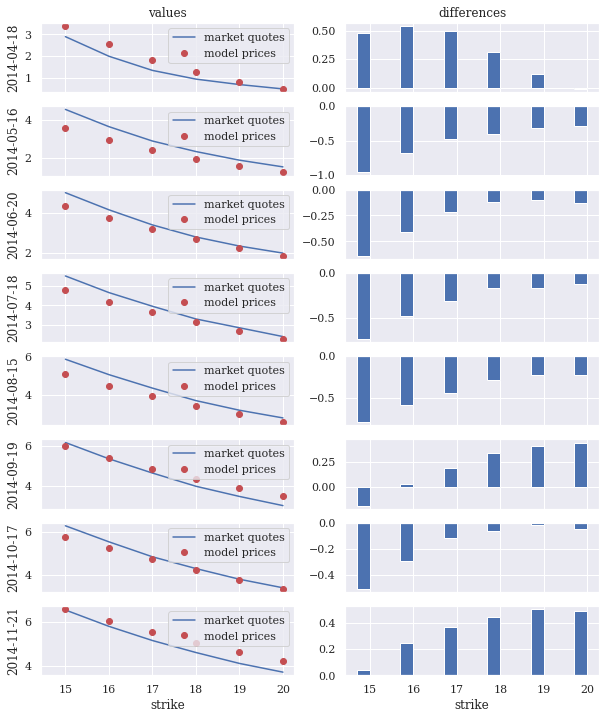

In [65]:
plot_calibration_results(option_data, opt_8_MSRE, mats)